In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

# 1. Load Data

In [2]:
df = pd.read_csv(os.path.join('data','train.csv'))

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# 2. Preprocessing

In [5]:
from tensorflow.keras.layers import TextVectorization

In [11]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [16]:
MAX_FEATURES = 200000 # number of words in the vocab

In [17]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length = 1800,
                               output_mode ='int')

In [18]:
vectorizer.adapt(X.values)

In [19]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'the',
 'to',
 'of',
 'and',
 'a',
 'you',
 'i',
 'is',
 'that',
 'in',
 'it',
 'for',
 'this',
 'not',
 'on',
 'be',
 'as',
 'have',
 'are',
 'your',
 'with',
 'if',
 'article',
 'was',
 'or',
 'but',
 'page',
 'my',
 'an',
 'from',
 'by',
 'do',
 'at',
 'about',
 'me',
 'so',
 'wikipedia',
 'can',
 'what',
 'there',
 'all',
 'has',
 'will',
 'talk',
 'please',
 'would',
 'its',
 'no',
 'one',
 'just',
 'like',
 'they',
 'he',
 'dont',
 'which',
 'any',
 'been',
 'should',
 'more',
 'we',
 'some',
 'other',
 'who',
 'see',
 'here',
 'also',
 'his',
 'think',
 'im',
 'because',
 'know',
 'how',
 'am',
 'people',
 'why',
 'edit',
 'articles',
 'only',
 'out',
 'up',
 'when',
 'were',
 'use',
 'then',
 'may',
 'time',
 'did',
 'them',
 'now',
 'being',
 'their',
 'than',
 'thanks',
 'even',
 'get',
 'make',
 'good',
 'had',
 'very',
 'information',
 'does',
 'could',
 'well',
 'want',
 'such',
 'sources',
 'way',
 'name',
 'these',
 'deletion',
 'pages',
 'first',
 'help'

In [20]:
vectorized_text = vectorizer(X.values)

In [21]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [24]:
batch_X,batch_y = dataset.as_numpy_iterator().next()

In [25]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [27]:
train_generator = train.as_numpy_iterator().next()

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [31]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1,32))
model.add(Bidirectional(LSTM(32,activation='tanh')))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

In [32]:
model.compile( loss = 'BinaryCrossentropy', optimizer = 'Adam')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [34]:
hist = model.fit(train, epochs = 1, validation_data=val)

6981/6981 [==============================] - 9569s 1s/step - loss: 0.0637 - val_loss: 0.0464


In [35]:
hist.history

{'loss': [0.06367778778076172], 'val_loss': [0.04637649282813072]}

In [36]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

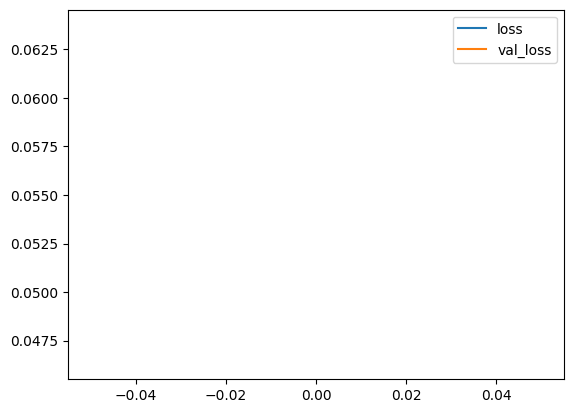

In [37]:
plt.figure(figsize= (8,5))
pd.DataFrame(hist.history).plot()
plt.show()

# 3. Make Predictions

In [38]:
batch_X,batch_y = test.as_numpy_iterator().next()

In [39]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [40]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [41]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 3s 3s/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [42]:
input_text = vectorizer('You Freaking suck! I am going to hurt you.')

In [45]:
model.predict(np.array([input_text]))
# model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 174ms/step


array([[0.98495924, 0.38314465, 0.9296312 , 0.10208528, 0.7053528 ,
        0.17150013]], dtype=float32)

In [46]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 182ms/step


# 4. Evaluate Model

In [47]:
from tensorflow.keras.metrics import Precision, Recall,CategoricalAccuracy

In [48]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [49]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
    

1/1 [==============================] - 0s 354ms/step


In [50]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


Precision: 0.8525769114494324, Recall:0.6135709881782532, Accuracy:0.454363077878952


# 5. Test and Gradio

In [ ]:
import tensorflow as tf
import gradio as gr




In [56]:
model.save('toxicity.h5')


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
model = tf.keras.models.load_model('toxicity.h5')


In [67]:
input_str = vectorizer('hey i freaken hate you!')


In [70]:
res = model.predict(np.expand_dims(input_str,0))>0.5


1/1 [==============================] - 0s 193ms/step


In [71]:
res

array([[ True, False, False, False, False, False]])

In [ ]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [ ]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

In [ ]:
interface.launch(share=True)